# How to run solvers

## What's a solver?

In this context, a solver is an entity which takes an initial field together with problem-specific parameters, then performs a numerical simulation and either provides on-the-fly output or just final results. Solvers are assembled in a modular fashion as will be illustrated below. The chosen timestepper and ODE class can be just-in-time compiled based on the given VoxelGrid backend.

## Example: Cahn-Hilliard equation

For the context of this little example we will focus on the periodic two-phase [Cahn-Hilliard equation](
https://doi.org/10.1063/1.1744102) which can be shortly summarized as follows:
We start from a free energy functional for a two-phase system

$$F_\text{int}=\int_{V} f_\text{int} \text{d}{V} = \gamma_0\int_{V}\epsilon|\nabla\phi|^2+\frac{9}{\epsilon}\phi^2(1-\phi)^2 \text{d}{V}$$

where $\gamma_0$ [$\text{m}^2$/s] denotes the interfacial energy and $\epsilon$ [m] scales the width of the diffuse interface. Note that in this case, the homogeneous free energy is given by a double-well potential while in the context of the Cahn-Hilliard equation a regular solution free energy involving logarithmic terms is often employed (see original work of [Cahn & Hilliard](
https://doi.org/10.1063/1.1744102)). However, the following procedure would be identical in all cases.

The second order phase transition problem - also known as the *Cahn-Hilliard equation* - can be derived by inserting the chemical potential $\mu=\delta f_\text{int}/\delta\psi$ given by the functional derivative of the given free energy formulation into the mass conservation equation which yields

$$\frac{\partial\phi}{\partial t}=\nabla\cdot\left(M\nabla\mu\right), \quad \mu= \gamma_0 g(\phi) - 2\gamma_0\epsilon\nabla^2 \phi$$

which is a fourth-order PDE in space. 
Specifically, we use a variable mobility of the form $M=D_0 \phi(1-\phi)$ and the homogenous part of the chemical potential is given by the polynomial expression $g(\phi)=\frac{18}{\epsilon}\phi(1-\phi)(1-2\phi)$ which is derived from the double-well potential in the energy functional.

## Execute the precompiled solver

We start by creating a VoxelFields object which is large enough to compare computation times. Random noise is used as the inital condition of the concentration field.

In [ ]:
import evoxels as vox
import numpy as np

Nx, Ny, Nz = [150, 150, 150]
vf = vox.VoxelFields((Nx, Ny, Nz), domain_size=(Nx, Ny, Nz))
noise = 0.5 + 0.1*(0.5-np.random.rand(Nx, Ny, Nz))
noise[0,:,:] = 0.1

`voxelsss` comes with precompiled solvers which can be used out of the box. One such solver is the `run_cahn_hilliard_solver()` which takes input arguments defining
- the numerical backend
- timestepping options
- problem-specific parameters
- output options

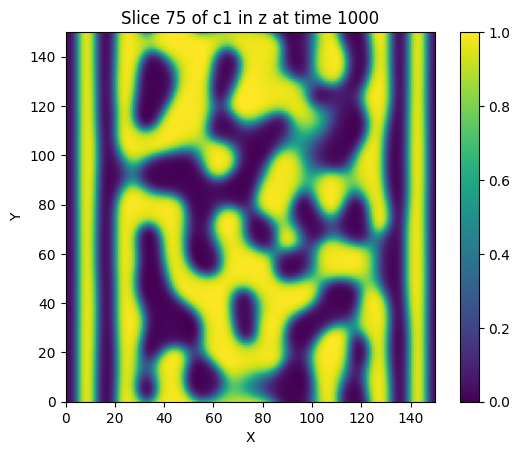

Wall time: 27.6428 s after 1000 iterations (0.0276 s/iter)
GPU-RAM (nvidia-smi)  current: 247 MB (247 MB max)
GPU-RAM (torch)       current: 32.70 MB (151.00 MB max, 162.00 MB reserved)


In [2]:
vf.add_field("c1", noise)

final_time = 1000
dt = 1
steps = int(final_time/dt)

vox.run_cahn_hilliard_solver(
    vf, 'c1', 'torch', jit=False, device='cuda',
    time_increment=dt, frames=10, max_iters=steps,
    eps = 3.0, diffusivity = 1.0,
    verbose='plot', vtk_out=False, plot_bounds=(0,1)
  )

## Assembling custom solvers

We can unwrap what is actually happening under the hood a bit more by manually assembling this solver based on the predefined problem definition, timestepper and solver framework. The `TimeDependentSolver` is a pre-defined class which initialises a scalar field and solves a time-dependent PDE (as opposed to a steady-state problem). This is done by combining a backend (`torch/jax`) with a timestepper (e.g. `pseudo_spectral_IMEX`) and a problem class which defines the numerical discretisation of the right-hand side of a PDE (e.g. `PeriodicCahnHilliard`).

In [ ]:
from evoxels.problem_definition import PeriodicCahnHilliard
from evoxels.solvers import TimeDependentSolver
from evoxels.timesteppers import pseudo_spectral_IMEX

# Add the same noise as a new field to the VoxelFields
# as c1 has been over-written by the previous solve call
vf.add_field("c2", noise)

solver = TimeDependentSolver(
        vf,      # VoxelFields object
        'c2',    # Name of initial field
        'torch', # Backend
        problem_cls = PeriodicCahnHilliard,    # Problem definition
        timestepper_fn = pseudo_spectral_IMEX, # Timestepping scheme
        device='cuda',
    )

solver.solve(
        time_increment=dt,
        frames=10,
        max_iters=steps,
        problem_kwargs={"eps": 3.0, "D": 1.0},
        jit=False,
        verbose=True,
        vtk_out=False,
        plot_bounds=(0,1),
    )

Wall time: 24.0701 s after 1000 iterations (0.0241 s/iter)
GPU-RAM (nvidia-smi)  current: 261 MB (261 MB max)
GPU-RAM (torch)       current: 39.40 MB (157.53 MB max, 176.00 MB reserved)


This yield the exact same outcome as we can see from the voxel-wise difference between the two solution fields

In [4]:
print(f"Maximal deviation: {np.max(np.abs(vf.fields['c1']-vf.fields['c2']))}")

Maximal deviation: 0.0


## Just-in-time compilation and wall time

So far, the just-in-time compilation has been turned off (`jit=False`) which means no code optimisation is done. Now, we set `jit=True` such that the timestepper and rhs definition will be compiled into one GPU kernel. This has two effects
1. The simulation is significantly faster when jit compiled
2. The field values deviate as the jit compiled kernel optimizes the order of additions, multiplications, etc.

The average of all absolute per-voxel deviations are still small but larger than float32 single precision (~7 significant decimal digits).

In [5]:
vf.add_field("c3", noise)

solver = TimeDependentSolver(
        vf, 'c3', 'torch', device='cuda',
        problem_cls = PeriodicCahnHilliard,
        timestepper_fn = pseudo_spectral_IMEX
    )

solver.solve(
        time_increment=dt, frames=10, max_iters=steps,
        problem_kwargs={"eps": 3.0, "D": 1.0},
        jit=True
    )

/home/daubners/miniconda3/envs/voxenv/lib/python3.12/site-packages/torch/_inductor/lowering.py:1917: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


Wall time: 19.3805 s after 1000 iterations (0.0194 s/iter)
GPU-RAM (nvidia-smi)  current: 287 MB (287 MB max)
GPU-RAM (torch)       current: 41.52 MB (96.42 MB max, 192.00 MB reserved)


In [15]:
print(f"Mean deviation: {np.mean(np.abs(vf.fields['c2']-vf.fields['c3']))}")

Mean deviation: 8.096617420960683e-06


Instead of the `pseudo_spectral_IMEX` timestepping scheme - aka [semi-implicit Fourier spectral method](
https://doi.org/10.1103/PhysRevE.60.3564) - we could use the simple forward Euler discretisation (`forward_euler`) which is an explicit method. It is first order accurate in time and the maximal timestep size is limited by the CFL condition. Therfore, the maximal time increment is much smaller compared to the previous case which leads to much longer simulation times.

In [ ]:
from evoxels.timesteppers import forward_euler

vf.add_field("c4", noise)
dt = 0.005

solver = TimeDependentSolver(
        vf, 'c4', 'torch', device='cuda',
        problem_cls = PeriodicCahnHilliard,
        timestepper_fn = forward_euler
    )

solver.solve(
        time_increment=dt, frames=10, max_iters=int(final_time/dt),
        problem_kwargs={"eps": 3.0, "D": 1.0},
        jit=True
    )

Wall time: 416.6265 s after 200000 iterations (0.0021 s/iter)
GPU-RAM (nvidia-smi)  current: 287 MB (287 MB max)
GPU-RAM (torch)       current: 48.83 MB (103.72 MB max, 192.00 MB reserved)


## Custom solver kernel

Instead of discretising the spatial gradients in the Cahn-Hilliard equation based on second order finite differences, we can go to Fourier space. This can be realised by writing your own custom solver kernel 

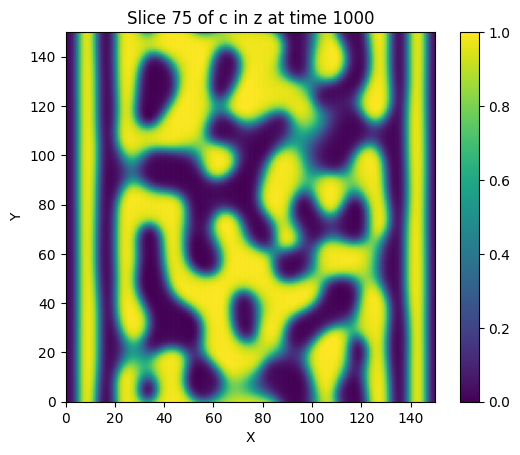

Wall time: 41.4113 s after 1000 iterations (0.0414 s/iter)
GPU-RAM (nvidia-smi)  current: 495 MB (495 MB max)
GPU-RAM (torch)       current: 59.88 MB (334.08 MB max, 400.00 MB reserved)


In [8]:
import torch
import torch.fft as fft

vf.add_field("c", noise)
dt = 1
eps = 3.0
D = 1.0
A = 0.25

# Define wavenumbers
fft_axes = tuple(2 * torch.pi * fft.fftfreq(points, step)
                     for points, step in zip(vf.shape, vf.spacing))
kx, ky, kz = torch.meshgrid(*fft_axes, indexing='ij')
k_squared = kx**2 + ky**2 + kz**2

# Define stepfunction
def custom_step_function(c, t):
    c = torch.clip(c, 0, 1)
    mu_hom = 18/eps * c * (1-c) * (1-2*c)
    c_hat = fft.fftn(c)
    mobility = D * c * (1-c)
    mu_hat = fft.fftn(mu_hom) + 2 * eps * k_squared * c_hat

    flux_x = mobility * torch.real(fft.ifftn(1j * kx * mu_hat))
    flux_y = mobility * torch.real(fft.ifftn(1j * ky * mu_hat))
    flux_z = mobility * torch.real(fft.ifftn(1j * kz * mu_hat))
    flux_div = 1j * (kx*fft.fftn(flux_x) + ky*fft.fftn(flux_y) + kz*fft.fftn(flux_z))
                    
    c_hat += dt*flux_div / (1 + 2*eps*dt*D*k_squared**2*A)
    return torch.real(fft.ifftn(c_hat))

# Solver setup and solve
solver = TimeDependentSolver(
        vf, 'c', 'torch', device='cuda',
        step_fn = custom_step_function
    )

solver.solve(
        time_increment=dt, frames=10, max_iters=int(final_time/dt),
        jit=False, verbose='plot', plot_bounds=(0,1)
    )

**Note: Complex operators cannot be jit compiled!** Torch will promt an error when `jit=True`.

## Callable chemical potential

ODE classes can be defined with callable input arguments. In case of the Cahn-Hilliard solver, the default homogeneous chemical potential is $g(\phi)=\frac{18}{\epsilon}\phi(1-\phi)(1-2\phi)$ which is derived from the double-well potential in the energy functional as discussed in the introduction. Alternatively, we can define $g(\phi)$ based on a regular solution free energy (see [Cahn & Hilliard](
https://doi.org/10.1063/1.1744102)) as $g(\phi)=\ln(\phi)-\ln(1-\phi) + \Omega(1-2\phi)$

Note that one input argument for the callable function must be `lib` as soon as backend specific functions such as `torch.log` or `jax.numpy.sin` are used. The solver will replace `lib` with the backend-specific library.

In [9]:
def regular_solution_mu(c, lib):
    return lib.log(c) - lib.log(1-c) + 3.0*(1-2*c)

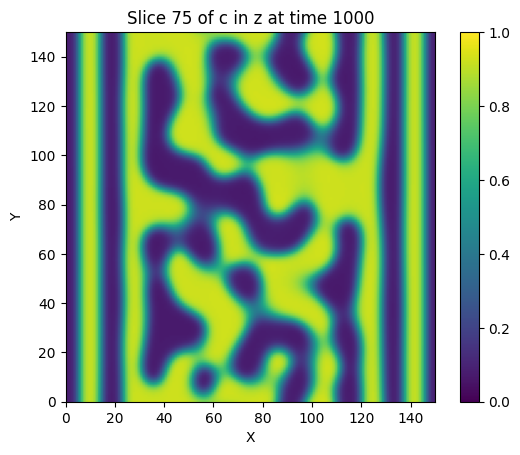

Wall time: 21.7926 s after 1000 iterations (0.0218 s/iter)
GPU-RAM (nvidia-smi)  current: 495 MB (495 MB max)
GPU-RAM (torch)       current: 53.28 MB (108.17 MB max, 400.00 MB reserved)


In [10]:
vf.add_field("c", noise)

dt = 1
steps = int(final_time/dt)

vox.run_cahn_hilliard_solver(
    vf, 'c', 'torch', jit=True, device='cuda',
    time_increment=dt, frames=10, max_iters=steps,
    eps = 3.0, diffusivity = 1.0, mu_hom = regular_solution_mu,
    verbose='plot', vtk_out=False, plot_bounds=(0,1)
  )

## Float precision and wall time

The float precision plays an immense roll for the runtime on a GPU as only single precision is naturally supported. The `torch/jax` backend inherits the float precision from the VoxelFields object. The default value is `float32` (single precision).

In [11]:
vf.precision

'float32'

In [12]:
vf.add_field("c", noise)

vox.run_cahn_hilliard_solver(
    vf, 'c', 'torch', jit=False, device='cuda',
    time_increment=dt, frames=10, max_iters=steps,
    eps = 3.0, diffusivity = 1.0
  )

Wall time: 24.1577 s after 1000 iterations (0.0242 s/iter)
GPU-RAM (nvidia-smi)  current: 495 MB (495 MB max)
GPU-RAM (torch)       current: 53.28 MB (171.65 MB max, 400.00 MB reserved)


We can intentionally set the float precision to double which might be necessary for small spacings dx **but this can mostly be circumvented by proper non-dimensionalisation!**

In [13]:
vf.precision = 'float64'

...and perform the same simulation again

In [14]:
vf.add_field("c", noise)

vox.run_cahn_hilliard_solver(
    vf, 'c', 'torch', jit=False, device='cuda',
    time_increment=dt, frames=10, max_iters=steps,
    eps = 3.0, diffusivity = 1.0
  )

Wall time: 54.3424 s after 1000 iterations (0.0543 s/iter)
GPU-RAM (nvidia-smi)  current: 609 MB (609 MB max)
GPU-RAM (torch)       current: 87.01 MB (322.59 MB max, 510.00 MB reserved)
